<a href="https://colab.research.google.com/github/Cosmox999/SOC-RL/blob/main/DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install numpy==1.23.5 gym==0.25.2

In [8]:
pip install pyvirtualdisplay

Training DDPG agent...


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1, Reward: -1171.82
Episode 2, Reward: -1869.42
Episode 3, Reward: -1164.87
Episode 4, Reward: -1457.87
Episode 5, Reward: -1609.03
Episode 6, Reward: -1611.52
Episode 7, Reward: -1591.09
Episode 8, Reward: -1620.46
Episode 9, Reward: -1550.67
Episode 10, Reward: -1374.08
Episode 11, Reward: -1366.48
Episode 12, Reward: -1286.35
Episode 13, Reward: -1176.84
Episode 14, Reward: -1143.21
Episode 15, Reward: -971.90
Episode 16, Reward: -976.35
Episode 17, Reward: -981.60
Episode 18, Reward: -1504.41
Episode 19, Reward: -1045.58
Episode 20, Reward: -1018.24
Episode 21, Reward: -898.56
Episode 22, Reward: -878.89
Episode 23, Reward: -874.73
Episode 24, Reward: -766.53
Episode 25, Reward: -895.29
Episode 26, Reward: -939.58
Episode 27, Reward: -1359.67
Episode 28, Reward: -1174.73
Episode 29, Reward: -1004.62
Episode 30, Reward: -1006.37
Episode 31, Reward: -823.70
Episode 32, Reward: -643.74
Episode 33, Reward: -755.07
Episode 34, Reward: -756.89
Episode 35, Reward: -718.93
Episode 

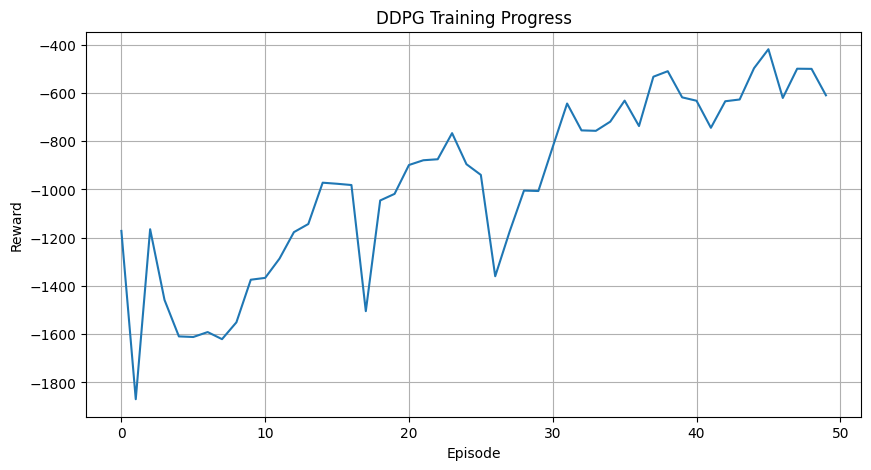


Recording video...


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Successfully recorded video to ddpg_pendulum.mp4


In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio
import os
import base64
from IPython.display import HTML, display
from pyvirtualdisplay import Display

# Set up virtual display for Colab
Display(visible=0, size=(1400, 900)).start()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.l1(state))
        a = torch.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        q = torch.relu(self.l1(torch.cat([state, action], 1)))
        q = torch.relu(self.l2(q))
        return self.l3(q)

# DDPG Agent
class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(1000000)

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0:
            action = (action + np.random.normal(0, noise, size=action.shape[0])).clip(-self.max_action, self.max_action)
        return action

    def train(self, batch_size=64, gamma=0.99, tau=0.005):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample from replay buffer
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # Critic loss
        next_action = self.actor_target(next_state)
        target_Q = self.critic_target(next_state, next_action.detach())
        target_Q = reward + (1 - done) * gamma * target_Q
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q.detach())

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self, filename):
        torch.save(self.actor.state_dict(), filename + "_actor.pth")
        torch.save(self.critic.state_dict(), filename + "_critic.pth")

    def load(self, filename):
        self.actor.load_state_dict(torch.load(filename + "_actor.pth"))
        self.critic.load_state_dict(torch.load(filename + "_critic.pth"))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

# Training function
def train_ddpg(env_name="Pendulum-v1", episodes=250):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    rewards = []

    for ep in range(1, episodes+1):
        state = env.reset()
        episode_reward = 0

        for t in range(200):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)
        print(f"Episode {ep}, Reward: {episode_reward:.2f}")

        # Save model periodically
        if ep % 20 == 0 or ep == episodes:
            agent.save("ddpg_pendulum")

    env.close()
    return agent, rewards

# Video recording function (optimized for Colab)
def record_video(env_name="Pendulum-v1", model_path=None, filename="ddpg_pendulum.mp4", num_episodes=1):
    # Create environment with render mode
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Initialize agent
    agent = DDPG(state_dim, action_dim, max_action)

    # Load model if path provided
    if model_path:
        agent.load(model_path)
    elif os.path.exists("ddpg_pendulum_actor.pth"):
        agent.load("ddpg_pendulum")
    else:
        raise ValueError("No model found to load")

    frames = []

    for ep in range(num_episodes):
        state = env.reset()

        for t in range(200):
            # Render to frames
            frame = env.render(mode='rgb_array')
            frames.append(frame)

            # Select action (no noise for evaluation)
            action = agent.select_action(state, noise=0)

            # Take step
            next_state, _, done, _ = env.step(action)
            state = next_state

            if done:
                break

    env.close()

    # Save video
    if frames:
        # Convert frames to uint8
        frames = [np.clip(frame, 0, 255).astype(np.uint8) for frame in frames]
        imageio.mimsave(filename, frames, fps=30)

        # Display video in Colab
        mp4 = open(filename,'rb').read()
        data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
        display(HTML(f"""
            <video width="400" controls>
                <source src="{data_url}" type="video/mp4">
            </video>
        """))
        return filename
    else:
        print("No frames captured")
        return None

# Main execution
if __name__ == "__main__":
    # Install required packages for Colab
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    # Train the agent (run this cell first)
    print("Training DDPG agent...")
    agent, rewards = train_ddpg(episodes=50)

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DDPG Training Progress")
    plt.grid()
    plt.show()

    # Record video (can be run separately later)
    print("\nRecording video...")
    video_file = record_video()

    if video_file:
        print(f"Successfully recorded video to {video_file}")
    else:
        print("Failed to record video")

Training DDPG agent for 250 episodes...
Starting training for 250 episodes...


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode   1/250 | Reward: -1316.07
Episode   2/250 | Reward: -1252.00
Episode   3/250 | Reward: -1356.62
Episode   4/250 | Reward: -1547.28
Episode   5/250 | Reward: -1489.41
Episode   6/250 | Reward: -1610.80
Episode   7/250 | Reward: -1439.86
Episode   8/250 | Reward: -1327.28
Episode   9/250 | Reward: -1524.82
Episode  10/250 | Reward: -1286.01
Episode  11/250 | Reward: -1530.50
Episode  12/250 | Reward: -1132.07
Episode  13/250 | Reward: -833.47
Episode  14/250 | Reward: -1545.00
Episode  15/250 | Reward: -986.96
Episode  16/250 | Reward: -1231.50
Episode  17/250 | Reward: -1064.10
Episode  18/250 | Reward: -977.76
Episode  19/250 | Reward: -1414.31
Episode  20/250 | Reward: -1175.35
Episode  21/250 | Reward: -1170.02
Episode  22/250 | Reward: -985.78
Episode  23/250 | Reward: -1467.98
Episode  24/250 | Reward: -987.30
Episode  25/250 | Reward: -977.66
Episode  26/250 | Reward: -771.19
Episode  27/250 | Reward: -989.15
Episode  28/250 | Reward: -1158.28
Episode  29/250 | Reward: -1

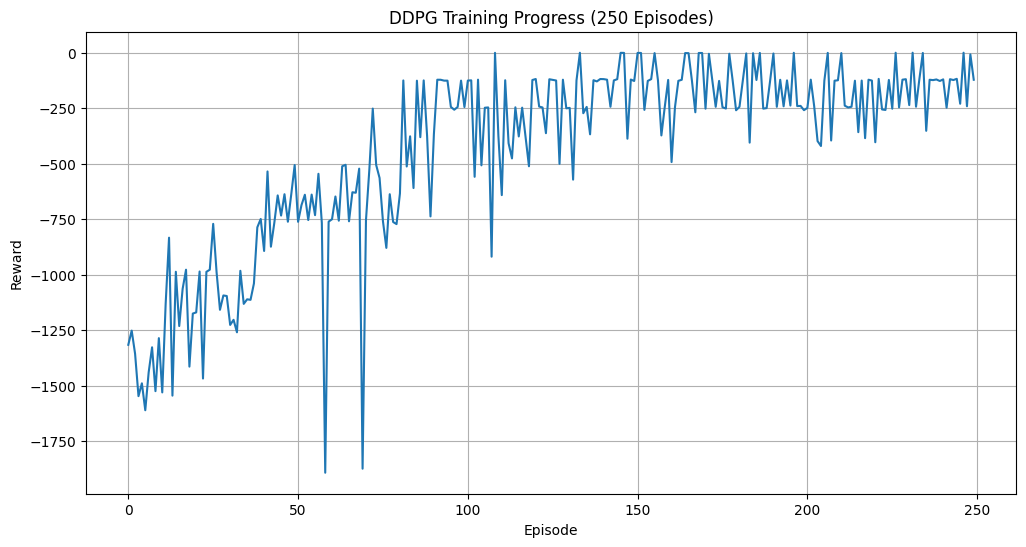


Recording evaluation video...


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Successfully recorded video to ddpg_pendulum.mp4


In [10]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio
import os
import base64
from IPython.display import HTML, display
from pyvirtualdisplay import Display

# Set up virtual display for Colab
Display(visible=0, size=(1400, 900)).start()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def __len__(self):
        return len(self.buffer)

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.l1(state))
        a = torch.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        q = torch.relu(self.l1(torch.cat([state, action], 1)))
        q = torch.relu(self.l2(q))
        return self.l3(q)

# DDPG Agent
class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(1000000)

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        if noise != 0:
            action = (action + np.random.normal(0, noise, size=action.shape[0])).clip(-self.max_action, self.max_action)
        return action

    def train(self, batch_size=64, gamma=0.99, tau=0.005):
        if len(self.replay_buffer) < batch_size:
            return

        # Sample from replay buffer
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # Critic loss
        next_action = self.actor_target(next_state)
        target_Q = self.critic_target(next_state, next_action.detach())
        target_Q = reward + (1 - done) * gamma * target_Q
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q.detach())

        # Optimize critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def save(self, filename):
        torch.save(self.actor.state_dict(), filename + "_actor.pth")
        torch.save(self.critic.state_dict(), filename + "_critic.pth")

    def load(self, filename):
        self.actor.load_state_dict(torch.load(filename + "_actor.pth"))
        self.critic.load_state_dict(torch.load(filename + "_critic.pth"))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

# Training function
def train_ddpg(env_name="Pendulum-v1", episodes=250):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)
    rewards = []

    print(f"Starting training for {episodes} episodes...")

    for ep in range(1, episodes+1):
        state = env.reset()
        episode_reward = 0

        for t in range(200):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            episode_reward += reward

            if done:
                break

        rewards.append(episode_reward)
        print(f"Episode {ep:3d}/{episodes} | Reward: {episode_reward:7.2f}")

        # Save model periodically
        if ep % 20 == 0 or ep == episodes:
            agent.save("ddpg_pendulum")

    env.close()
    return agent, rewards

# Video recording function
def record_video(env_name="Pendulum-v1", model_path=None, filename="ddpg_pendulum.mp4", num_episodes=1):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    agent = DDPG(state_dim, action_dim, max_action)

    if model_path:
        agent.load(model_path)
    elif os.path.exists("ddpg_pendulum_actor.pth"):
        agent.load("ddpg_pendulum")
    else:
        raise ValueError("No model found to load")

    frames = []

    for ep in range(num_episodes):
        state = env.reset()

        for t in range(200):
            frame = env.render(mode='rgb_array')
            frames.append(frame)

            action = agent.select_action(state, noise=0)
            next_state, _, done, _ = env.step(action)
            state = next_state

            if done:
                break

    env.close()

    if frames:
        frames = [np.clip(frame, 0, 255).astype(np.uint8) for frame in frames]
        imageio.mimsave(filename, frames, fps=30)

        mp4 = open(filename,'rb').read()
        data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
        display(HTML(f"""
            <video width="400" controls>
                <source src="{data_url}" type="video/mp4">
            </video>
        """))
        return filename
    else:
        print("No frames captured")
        return None

# Main execution
if __name__ == "__main__":
    # Install required packages for Colab
    !pip install gym pyvirtualdisplay > /dev/null 2>&1
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

    # Train the agent for 250 episodes
    print("Training DDPG agent for 250 episodes...")
    agent, rewards = train_ddpg(episodes=250)

    # Plot rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DDPG Training Progress (250 Episodes)")
    plt.grid()
    plt.show()

    # Record and display video
    print("\nRecording evaluation video...")
    video_file = record_video()

    if video_file:
        print(f"Successfully recorded video to {video_file}")
    else:
        print("Failed to record video")